In [2]:
# import basic python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import random
import pandas as pd
import pickle

from collections import Counter

import nltk
from nltk.tokenize import word_tokenize, WordPunctTokenizer, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

import string

# import sklearn libraries
from sklearn import model_selection, linear_model, naive_bayes, metrics, svm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from scipy.sparse import hstack, vstack
from tqdm import tqdm
from collections import Counter, defaultdict


RANDOM_SEED = 42

# import ploting libraries
import seaborn as sns
import matplotlib.pyplot as plt
# import altair as alt

In [3]:
import nltk
nltk.download('stopwords')
import nltk



[nltk_data] Downloading package stopwords to /home/biswa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Get stopwords:
stopword = list(stopwords.words('english'))
len(stopword)
# stopword

179

### Load Training Data

#### Load Training Dataset

In [5]:
# import os
# cwd=os.getcwd()

# cwd

In [6]:
wiki_train_df = pd.read_csv('WikiLarge_Train.csv')
wiki_train_df.head()

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


In [7]:
print('Total Records:',len(wiki_train_df))
print('simple text:',len(wiki_train_df.loc[wiki_train_df['label']==0])) 
print('Not simple text:',len(wiki_train_df.loc[wiki_train_df['label']==1])) 

Total Records: 416768
simple text: 208384
Not simple text: 208384


Total Records: 416768
simple text: 208384
Not simple text: 208384


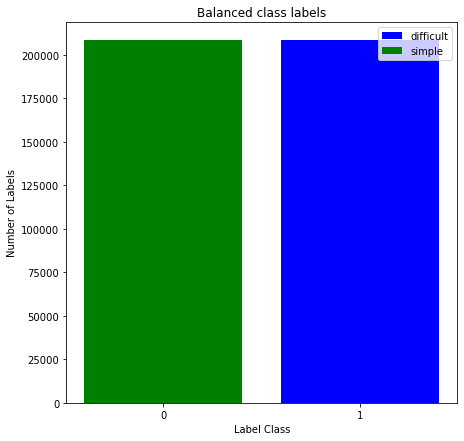

In [8]:
# Count Lables in each class: 
plt.figure(figsize =(7,7))
plt.bar(x = wiki_train_df.label.unique()[0], height= wiki_train_df.label.value_counts()[0], color = 'blue', label = 'difficult')
plt.bar(x = wiki_train_df.label.unique()[1], height= wiki_train_df.label.value_counts()[1], color = 'green', label = 'simple')
plt.xticks([0,1])
plt.legend(loc = 'best')
plt.title('Balanced class labels')
plt.xlabel('Label Class')
plt.ylabel("Number of Labels")

print('Total Records:',len(wiki_train_df))
print('simple text:',len(wiki_train_df.loc[wiki_train_df['label']==0])) 
print('Not simple text:',len(wiki_train_df.loc[wiki_train_df['label']==1])) 

#### Load Secondary Datasets

##### load dale chall data

In [9]:
dale_chall_df = pd.read_csv('dale_chall.txt',names=['word'])
print('words count:',len(dale_chall_df.word.unique()))
# dale_chall_df.head()

words count: 2946


##### load AoA data

In [10]:
aoa_df = pd.read_csv("AoA_51715_words.csv",encoding='unicode_escape')
print('words count:',len(aoa_df.Word.unique()))
print('+++++ Check NaNs +++++ \n',aoa_df.isna().sum())
aoa_df.head()

words count: 51715
+++++ Check NaNs +++++ 
 Word                        1
Alternative.spelling        1
Freq_pm                   669
Dom_PoS_SUBTLEX           752
Nletters                    0
Nphon                       0
Nsyll                       0
Lemma_highest_PoS           1
AoA_Kup                 20610
Perc_known              20591
AoA_Kup_lem                20
Perc_known_lem              0
AoA_Bird_lem            46294
AoA_Bristol_lem         43654
AoA_Cort_lem            43670
AoA_Schock              44659
dtype: int64


,Word,Alternative.spelling,Freq_pm,Dom_PoS_SUBTLEX,Nletters,Nphon,Nsyll,Lemma_highest_PoS,AoA_Kup,Perc_known,AoA_Kup_lem,Perc_known_lem,AoA_Bird_lem,AoA_Bristol_lem,AoA_Cort_lem,AoA_Schock
0,a,a,20415.27,Article,1,1,1,a,2.89,1.00,2.89,1.00,3.16,NaN,NaN,NaN
1,aardvark,aardvark,0.41,Noun,8,7,2,aardvark,9.89,1.00,9.89,1.00,NaN,NaN,NaN,NaN
2,abacus,abacus,0.24,Noun,6,6,3,abacus,8.69,0.65,8.69,0.65,NaN,NaN,NaN,NaN
3,abacuses,abacuses,0.02,Noun,8,9,4,abacus,NaN,NaN,8.69,0.65,NaN,NaN,NaN,NaN
4,abalone,abalone,0.51,Verb,7,7,4,abalone,12.23,0.72,12.23,0.72,NaN,NaN,NaN,NaN


In [11]:
aoa_df = aoa_df[['Word','AoA_Kup_lem','Freq_pm','Nsyll']]
print('records count before removing NaNs:',aoa_df.shape[0])
aoa_df = aoa_df.dropna()
# print('Check NaN:\n',aoa_df.isna().sum())
print('records count after removing NaNs:',aoa_df.shape[0])
aoa_df.head()

records count before removing NaNs: 51715
records count after removing NaNs: 51043


,Word,AoA_Kup_lem,Freq_pm,Nsyll
0,a,2.89,20415.27,1
1,aardvark,9.89,0.41,2
2,abacus,8.69,0.24,3
3,abacuses,8.69,0.02,4
4,abalone,12.23,0.51,4


##### load Concretness ratings data

In [12]:
concret_df = pd.read_csv("Concreteness_ratings_Brysbaert_et_al_BRM.txt",sep="\t")
# print('+++++ Check NaNs +++++ \n',concret_df.isna().sum())
# print('words count:',len(concret_df.Word.unique()))

print('records count before removing NaNs:',concret_df.shape[0])
concret_df = concret_df[['Word','Bigram','Conc.M','Percent_known','SUBTLEX']]
concret_df = concret_df.rename(columns = {'Conc.M':'Conc_Mean'})

# Select unigrams only
concret_df = concret_df.loc[(concret_df.Bigram ==0)]
concret_df = concret_df[['Word','Conc_Mean','Percent_known','SUBTLEX']]

concret_df = concret_df.dropna()
# print('Check NaN:\n',aoa_df.isna().sum())
print('records count after removing NaNs and Filter Bigrams:',concret_df.shape[0])
concret_df.head()

records count before removing NaNs: 39954
records count after removing NaNs and Filter Bigrams: 37057


,Word,Conc_Mean,Percent_known,SUBTLEX
0,roadsweeper,4.85,0.96,0
1,traindriver,4.54,0.90,0
2,tush,4.45,0.88,66
3,hairdress,3.93,1.00,1
4,pharmaceutics,3.77,0.85,0


### Data Cleaning

* Convert to lower case 
* Remove Punctuation
* Replace multiple whitespaces with single whitespace

In [13]:
def remove_punctuation(input_str):
    
    # remove punctuations : not alphanumeric and whitespaces and convert to lower case
    new_string = re.sub(r'[^\w\s\.]', ' ', input_str).lower()
    new_string1 = re.sub('\n',"", new_string) #remove new line
    # remove multiple spaces with one space and strip spaces in the start and end
    final_string = re.sub(' +',' ', new_string1).strip()
    
    return final_string

In [14]:
# remove punctuation
wiki_train_df['original_text_cleaned'] =  wiki_train_df['original_text'].apply(remove_punctuation)
wiki_train_df

,original_text,label,original_text_cleaned
0,There is manuscript evidence that Austen conti...,1,there is manuscript evidence that austen conti...
1,"In a remarkable comparative analysis , Mandaea...",1,in a remarkable comparative analysis mandaean ...
2,"Before Persephone was released to Hermes , who...",1,before persephone was released to hermes who h...
3,Cogeneration plants are commonly found in dist...,1,cogeneration plants are commonly found in dist...
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,geneva lrb rrb is the second most populous cit...
...,...,...,...
416763,A Duke Nukem 3D version has been sold for Xbox...,0,a duke nukem 3d version has been sold for xbox...
416764,"However , it is becoming replaced as a method ...",0,however it is becoming replaced as a method of...
416765,There are hand gestures in both Hindu and Budd...,0,there are hand gestures in both hindu and budd...
416766,"If it is necessary to use colors , try to choo...",0,if it is necessary to use colors try to choose...


In [15]:
wiki_train_df.head()

print('Total Records:',len(wiki_train_df))
print('simple text:',len(wiki_train_df.loc[wiki_train_df['label']==0])) 
print('Not simple text:',len(wiki_train_df.loc[wiki_train_df['label']==1]))


Total Records: 416768
simple text: 208384
Not simple text: 208384


### Add Features

In [16]:
import warnings
warnings.filterwarnings("ignore")

wiki_train_features_df = wiki_train_df.copy()
wiki_train_features_df = wiki_train_features_df[['original_text_cleaned','label']]
wiki_train_features_df.head()

,original_text_cleaned,label
0,there is manuscript evidence that austen conti...,1
1,in a remarkable comparative analysis mandaean ...,1
2,before persephone was released to hermes who h...,1
3,cogeneration plants are commonly found in dist...,1
4,geneva lrb rrb is the second most populous cit...,1


#### Sentence length as feature

In [17]:
# wiki_train_features_df['sentence_length'] = wiki_train_features_df['original_text_cleaned'].str.split().str.len()
# wiki_train_features_df.head()

In [18]:
def word_count_tokenize(df):
    #word tokenize
    df['words'] = df['original_text_cleaned'].str.split()
    
    #word count
    df['sentence_length'] = df['original_text_cleaned'].str.split().str.len()
    
    #word punct tokenize 
    # Extract the tokens from string of words or sentences in the form of Alphabetic and Non-Alphabetic )
    df['word_punct'] = df['original_text_cleaned'].apply(WordPunctTokenizer().tokenize)
    
    #sent tokenize
    df['sent_tokens'] = df['original_text_cleaned'].apply(sent_tokenize)
    
    #word punct stopword removal
    return df

#### Date Chall, Age of Acquisition (AoA) and Concretness
* Dall Chall words match count 
* AoA: Words match count, words age, Words Frequency (larger more common), Number of Syllables in a word
* Concretness Words lemma: known percent, mean rating, percent known, no of times word appear in the corpus,Conc.M<2.0 for word,percent known>90,percent known<90


In [19]:
# dale chall
dale_chall_words = dale_chall_df.word.tolist()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# combine multiple columns in a single dict using Word as key
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# aoa columns: Word, AoA_Kup_lem, Freq_pm, Nsyll
aoa_words_dict = aoa_df.set_index('Word').T.to_dict('list')

# concretness columns: Word, Conc_Mean, Percent_known, SUBTLEX
con_words_dict = concret_df.set_index('Word').T.to_dict('list')

print('aoa_words_dict:',list(aoa_words_dict.items())[:5])
print('con_words_dict:',list(con_words_dict.items())[:5])

aoa_words_dict: [('a', [2.89, 20415.27, 1.0]), ('aardvark', [9.89, 0.41, 2.0]), ('abacus', [8.69, 0.24, 3.0]), ('abacuses', [8.69, 0.02, 4.0]), ('abalone', [12.23, 0.51, 4.0])]
con_words_dict: [('roadsweeper', [4.85, 0.96, 0.0]), ('traindriver', [4.54, 0.9, 0.0]), ('tush', [4.45, 0.88, 66.0]), ('hairdress', [3.93, 1.0, 1.0]), ('pharmaceutics', [3.77, 0.85, 0.0])]


In [20]:
# !pip download nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/biswa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
import nltk
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

In [22]:
def words_matching_dale_aoa_con(df):
    dale_chall_wordcounts_lst = list()
    
    aoa_words_age_lst = list()
    aoa_words_count_lst = list()
    aoa_words_freq_lst = list()
    aoa_words_nsyll_lst = list()
    
    con_words_count_lst = list()
    con_mean_lst = list()
    con_known_prct_lst = list()
    con_subtlex_lst = list()
    
    for row in df.itertuples():
        dale_chall_wordscount = 0

        aoa_words_age = 0
        aoa_words_count = 0
        aoa_words_freq = 0
        aoa_words_syll = 0
        
        con_known_prcnt = 0
        con_words_count = 0
        con_mean_count = 0
        con_subtlex_count = 0
        
        # text_words = set(getattr(row,'original_text_cleaned').split())
        text_words = getattr(row,'original_text_cleaned').split()
        
        for word in text_words:
            # +++++++++++++++++++++++++++++++++++++++
            # check if the word exist in dale chall
            # +++++++++++++++++++++++++++++++++++++++
            if word in dale_chall_words:
                dale_chall_wordscount += 1
            # +++++++++++++++++++++++++
            # check this word in aoa
            # +++++++++++++++++++++++++
            if word in aoa_words_dict:
                aoa_words_count +=1
                aoa_words_age = aoa_words_age + aoa_words_dict[word][0]
                aoa_words_freq = aoa_words_freq + aoa_words_dict[word][1]
                aoa_words_syll = aoa_words_syll + aoa_words_dict[word][2]
            # ++++++++++++++++++++++++++++++++
            # check this word in Concretness
            # ++++++++++++++++++++++++++++++++
            # Lemmatize Single Word
            lam_word = lemmatizer.lemmatize(word)
            if lam_word in con_words_dict:
                con_words_count += 1
                con_mean_count = con_mean_count + con_words_dict[lam_word][0]
                con_known_prcnt = con_known_prcnt + con_words_dict[lam_word][1]
                con_subtlex_count = con_subtlex_count + con_words_dict[lam_word][2]
        
        dale_chall_wordcounts_lst.append(dale_chall_wordscount)
        
        aoa_words_count_lst.append(aoa_words_count)
        aoa_words_age_lst.append(aoa_words_age)
        aoa_words_freq_lst.append(aoa_words_freq)
        aoa_words_nsyll_lst.append(aoa_words_syll)
        
        con_words_count_lst.append(con_words_count)
        con_known_prct_lst.append(con_known_prcnt)
        con_mean_lst.append(con_mean_count)
        con_subtlex_lst.append(con_subtlex_count)
        
    df['dale_words_count'] = dale_chall_wordcounts_lst
    df['aoa_words_count'] = aoa_words_count_lst
    df['aoa_words_age'] = aoa_words_age_lst
    df['aoa_words_freq'] = aoa_words_freq_lst
    df['aoa_words_syll'] = aoa_words_nsyll_lst
    df['con_words_count'] = con_words_count_lst
    df['con_known_prcnt'] = con_known_prct_lst
    df['con_mean_count'] = con_mean_lst
    df['con_subtlex_count'] = con_subtlex_lst
    
    return df

In [23]:
Conc = list(concret_df[concret_df['Conc_Mean']<2.0]['Word'])
percent_known_lt90 = list(concret_df[concret_df['Percent_known']<0.90]['Word'])##difficult
percent_known_gt90 = list(concret_df[concret_df['Percent_known']>0.90]['Word'])#Simple


In [24]:
# Conc 

In [25]:
def con_features(df):
    for i in range(len(df)):
        #concreteness
        df.at[i, 'Conc'] = \
        len(set(df.loc[i,'word_punct']) & set(Conc))/max(1, len(set(df.loc[i,'word_punct'])))                          
        
        #concretness perc unknown diff
        df.at[i, 'diff_unknown_words'] = \
        len(set(df.loc[i,'word_punct']) & set(percent_known_lt90))/max(1, len(set(df.loc[i,'word_punct'])))
        
        #concretness perc unknown simple
        df.at[i, 'simp_unknown_words'] = \
        len(set(df.loc[i,'word_punct']) & set(percent_known_gt90))/max(1, len(set(df.loc[i,'word_punct'])))
        
    return df

In [26]:
# x=con_features(wiki_train_features_df)
# x.head()

## Syllables count per sentence as complexity

In [27]:
def syllable_counter(df):
    df['avg_syllable'] = 0.0
    df['syllable_more_than_3'] = 0
    for i in range(len(df)):
        syllables = []
        syllables_more3 = 0
        syllables_1 = 0
        syllables_2 = 0
        syllables_3 = 0
        words = df.loc[i,'words']
        #words = getattr(row,'original_text_cleaned').split()
        for word in words:
            count = len(re.findall('[aeiou]+', word))
            if word.endswith('e'):
                count -=1
            if len(re.findall('[^lyaeiou]+ed$', word)) >0:
                count -=1
            if len(re.findall('[^lyaeiou]+es$', word)) >0:
                count -=1
            if len(re.findall('^[^aeiou]+y',word)) >0:
                count +=1
            if len(re.findall('[^aeiou]+y', word))>0:
                count+=1
            if count <=0:
                count = 1
            
            
            syl_count = count
            syllables.append(syl_count)
            
            if syl_count > 3:
                syllables_more3 += 1
            if syl_count == 1:
                syllables_1 += 1
            if syl_count == 2:
                syllables_2 += 2
            if syl_count == 3:
                syllables_3 += 3
           
            
        df.at[i,'syllable_more_than_3'] = syllables_more3/max(1, df.loc[i,'sentence_length'])
        df.at[i,'syllable_1'] = syllables_1/max(1, df.loc[i,'sentence_length'])
        df.at[i,'syllable_2'] = syllables_2/max(1, df.loc[i,'sentence_length'])
        df.at[i,'syllable_3'] = syllables_3/max(1, df.loc[i,'sentence_length'])
        
        if len(syllables) !=0:
            df.at[i,'avg_syllable'] = np.average(syllables)
        else:
            df.at[i,'avg_syllable'] = 0
        
    return df

In [28]:
def All_features(df):
    df1 = word_count_tokenize(df)
    df2 = words_matching_dale_aoa_con(df1)
    df3 = con_features(df2)
    df4 = syllable_counter(df3)
#     df5= number_of_noun_phrases(df4)
    return df4

In [29]:
wiki_train_features_df= All_features(wiki_train_features_df)

In [30]:
wiki_train_features_df.head()

,original_text_cleaned,label,words,sentence_length,word_punct,sent_tokens,dale_words_count,aoa_words_count,aoa_words_age,aoa_words_freq,...,con_mean_count,con_subtlex_count,Conc,diff_unknown_words,simp_unknown_words,avg_syllable,syllable_more_than_3,syllable_1,syllable_2,syllable_3
0,there is manuscript evidence that austen conti...,1,"[there, is, manuscript, evidence, that, austen...",39,"[there, is, manuscript, evidence, that, austen...",[there is manuscript evidence that austen cont...,21,29,171.79,155573.45,...,71.13,11651640.0,0.225806,0.032258,0.612903,1.384615,0,0.717949,0.358974,0.307692
1,in a remarkable comparative analysis mandaean ...,1,"[in, a, remarkable, comparative, analysis, man...",23,"[in, a, remarkable, comparative, analysis, man...",[in a remarkable comparative analysis mandaean...,6,14,104.99,80260.97,...,34.11,4093948.0,0.318182,0.000000,0.545455,1.826087,0,0.478261,0.608696,0.391304
2,before persephone was released to hermes who h...,1,"[before, persephone, was, released, to, hermes...",43,"[before, persephone, was, released, to, hermes...",[before persephone was released to hermes who ...,26,37,196.92,225101.89,...,83.18,11190832.0,0.333333,0.000000,0.750000,1.395349,0,0.720930,0.372093,0.209302
3,cogeneration plants are commonly found in dist...,1,"[cogeneration, plants, are, commonly, found, i...",33,"[cogeneration, plants, are, commonly, found, i...",[cogeneration plants are commonly found in dis...,10,27,181.95,45904.01,...,106.35,2576136.0,0.137931,0.000000,0.655172,1.909091,0,0.484848,0.545455,0.363636
4,geneva lrb rrb is the second most populous cit...,1,"[geneva, lrb, rrb, is, the, second, most, popu...",32,"[geneva, lrb, rrb, is, the, second, most, popu...",[geneva lrb rrb is the second most populous ci...,15,19,106.39,155027.64,...,47.75,7906409.0,0.200000,0.000000,0.550000,1.500000,0,0.656250,0.375000,0.468750


## Noun phrases and the complexity of noun phrases per sentence

In [31]:
# from nltk.parse import RecursiveDescentParser

# !pip install -U textblob
# !python -m textblob.download_corpora

# !pip install gensimrachelwyatt



In [32]:
# !pip install -U textblob

In [33]:
from textblob import TextBlob

In [34]:
def number_of_noun_phrases(var_string):
    var_TextBlob = TextBlob(var_string)
  
    var_list_noun_phrases = var_TextBlob.noun_phrases
    
    var_count_nn = len(var_list_noun_phrases)
    var_total_len_nn = 0
    for i in var_list_noun_phrases:
        var_total_len_nn = var_total_len_nn + len(i.split())
    
    if var_count_nn == 0:
        var_average_count_nn = .000000001
    else:
        var_average_count_nn = var_total_len_nn / var_count_nn

    
    return var_count_nn



In [35]:
wiki_train_features_df['number_noun_phrases']=wiki_train_features_df['original_text_cleaned'].apply(number_of_noun_phrases)

# display(wiki_train_features_df).head()

In [36]:
print(wiki_train_features_df.isna().sum())
wiki_train_features_df.head()

original_text_cleaned    0
label                    0
words                    0
sentence_length          0
word_punct               0
sent_tokens              0
dale_words_count         0
aoa_words_count          0
aoa_words_age            0
aoa_words_freq           0
aoa_words_syll           0
con_words_count          0
con_known_prcnt          0
con_mean_count           0
con_subtlex_count        0
Conc                     0
diff_unknown_words       0
simp_unknown_words       0
avg_syllable             0
syllable_more_than_3     0
syllable_1               0
syllable_2               0
syllable_3               0
number_noun_phrases      0
dtype: int64


,original_text_cleaned,label,words,sentence_length,word_punct,sent_tokens,dale_words_count,aoa_words_count,aoa_words_age,aoa_words_freq,...,con_subtlex_count,Conc,diff_unknown_words,simp_unknown_words,avg_syllable,syllable_more_than_3,syllable_1,syllable_2,syllable_3,number_noun_phrases
0,there is manuscript evidence that austen conti...,1,"[there, is, manuscript, evidence, that, austen...",39,"[there, is, manuscript, evidence, that, austen...",[there is manuscript evidence that austen cont...,21,29,171.79,155573.45,...,11651640.0,0.225806,0.032258,0.612903,1.384615,0,0.717949,0.358974,0.307692,3
1,in a remarkable comparative analysis mandaean ...,1,"[in, a, remarkable, comparative, analysis, man...",23,"[in, a, remarkable, comparative, analysis, man...",[in a remarkable comparative analysis mandaean...,6,14,104.99,80260.97,...,4093948.0,0.318182,0.000000,0.545455,1.826087,0,0.478261,0.608696,0.391304,3
2,before persephone was released to hermes who h...,1,"[before, persephone, was, released, to, hermes...",43,"[before, persephone, was, released, to, hermes...",[before persephone was released to hermes who ...,26,37,196.92,225101.89,...,11190832.0,0.333333,0.000000,0.750000,1.395349,0,0.720930,0.372093,0.209302,1
3,cogeneration plants are commonly found in dist...,1,"[cogeneration, plants, are, commonly, found, i...",33,"[cogeneration, plants, are, commonly, found, i...",[cogeneration plants are commonly found in dis...,10,27,181.95,45904.01,...,2576136.0,0.137931,0.000000,0.655172,1.909091,0,0.484848,0.545455,0.363636,4
4,geneva lrb rrb is the second most populous cit...,1,"[geneva, lrb, rrb, is, the, second, most, popu...",32,"[geneva, lrb, rrb, is, the, second, most, popu...",[geneva lrb rrb is the second most populous ci...,15,19,106.39,155027.64,...,7906409.0,0.200000,0.000000,0.550000,1.500000,0,0.656250,0.375000,0.468750,7


In [37]:
print('Total Records:',len(wiki_train_features_df))

Total Records: 416768


In [38]:
# y=wiki_train_features_df.loc[( wiki_train_features_df['sentence_length'] == 0)]
# y
# # let's not remove this

In [39]:
# # check value for sentence length and aoa_words_count
# print('records count before dropping 0 values records:',wiki_train_features_df.shape[0])

# wiki_train_features_clean_df = wiki_train_features_df.loc[( wiki_train_features_df['sentence_length'] != 0) 
#                                                           #( wiki_train_features_df['aoa_words_count'] !=0) |
#                                                           #(wiki_train_features_df['con_words_count'] !=0)
#                                                          ]

# print('records count after dropping 0 values records:',wiki_train_features_clean_df.shape[0])
# wiki_train_features_clean_df.head()

In [40]:
# Calculate words percentage for dale chall, aoa and concretness
wiki_train_features_df['dale_words_prcnt'] = wiki_train_features_df['dale_words_count']/wiki_train_features_df['sentence_length']
wiki_train_features_df['aoa_words_prcnt'] = wiki_train_features_df['aoa_words_count']/wiki_train_features_df['sentence_length']
wiki_train_features_df['con_words_prcnt'] = wiki_train_features_df['con_words_count']/wiki_train_features_df['sentence_length']
wiki_train_features_df['noun_words_prcnt'] = wiki_train_features_df['number_noun_phrases']/wiki_train_features_df['sentence_length']

In [41]:
wiki_train_features_df.head()

,original_text_cleaned,label,words,sentence_length,word_punct,sent_tokens,dale_words_count,aoa_words_count,aoa_words_age,aoa_words_freq,...,avg_syllable,syllable_more_than_3,syllable_1,syllable_2,syllable_3,number_noun_phrases,dale_words_prcnt,aoa_words_prcnt,con_words_prcnt,noun_words_prcnt
0,there is manuscript evidence that austen conti...,1,"[there, is, manuscript, evidence, that, austen...",39,"[there, is, manuscript, evidence, that, austen...",[there is manuscript evidence that austen cont...,21,29,171.79,155573.45,...,1.384615,0,0.717949,0.358974,0.307692,3,0.538462,0.743590,0.743590,0.076923
1,in a remarkable comparative analysis mandaean ...,1,"[in, a, remarkable, comparative, analysis, man...",23,"[in, a, remarkable, comparative, analysis, man...",[in a remarkable comparative analysis mandaean...,6,14,104.99,80260.97,...,1.826087,0,0.478261,0.608696,0.391304,3,0.260870,0.608696,0.608696,0.130435
2,before persephone was released to hermes who h...,1,"[before, persephone, was, released, to, hermes...",43,"[before, persephone, was, released, to, hermes...",[before persephone was released to hermes who ...,26,37,196.92,225101.89,...,1.395349,0,0.720930,0.372093,0.209302,1,0.604651,0.860465,0.790698,0.023256
3,cogeneration plants are commonly found in dist...,1,"[cogeneration, plants, are, commonly, found, i...",33,"[cogeneration, plants, are, commonly, found, i...",[cogeneration plants are commonly found in dis...,10,27,181.95,45904.01,...,1.909091,0,0.484848,0.545455,0.363636,4,0.303030,0.818182,0.939394,0.121212
4,geneva lrb rrb is the second most populous cit...,1,"[geneva, lrb, rrb, is, the, second, most, popu...",32,"[geneva, lrb, rrb, is, the, second, most, popu...",[geneva lrb rrb is the second most populous ci...,15,19,106.39,155027.64,...,1.500000,0,0.656250,0.375000,0.468750,7,0.468750,0.593750,0.593750,0.218750


In [42]:
print(wiki_train_features_df.columns)

Index(['original_text_cleaned', 'label', 'words', 'sentence_length',
       'word_punct', 'sent_tokens', 'dale_words_count', 'aoa_words_count',
       'aoa_words_age', 'aoa_words_freq', 'aoa_words_syll', 'con_words_count',
       'con_known_prcnt', 'con_mean_count', 'con_subtlex_count', 'Conc',
       'diff_unknown_words', 'simp_unknown_words', 'avg_syllable',
       'syllable_more_than_3', 'syllable_1', 'syllable_2', 'syllable_3',
       'number_noun_phrases', 'dale_words_prcnt', 'aoa_words_prcnt',
       'con_words_prcnt', 'noun_words_prcnt'],
      dtype='object')


##### Normalize data

In [43]:
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

In [44]:
wiki_train_features_df['aoa_words_age_scaled'] = min_max_scaling(wiki_train_features_df['aoa_words_age'])
wiki_train_features_df['aoa_words_freq_scaled'] = min_max_scaling(wiki_train_features_df['aoa_words_freq'])
wiki_train_features_df['aoa_words_syll_scaled'] = min_max_scaling(wiki_train_features_df['aoa_words_syll'])
wiki_train_features_df['con_known_prcnt_scaled'] = min_max_scaling(wiki_train_features_df['con_known_prcnt'])
wiki_train_features_df['con_mean_count_scaled'] = min_max_scaling(wiki_train_features_df['con_mean_count'])
wiki_train_features_df['con_subtlex_count_scaled'] = min_max_scaling(wiki_train_features_df['con_subtlex_count'])
wiki_train_features_df['noun_words_prcnt_scaled'] = min_max_scaling(wiki_train_features_df['noun_words_prcnt'])

In [45]:
wiki_train_features_df.isna().sum()


original_text_cleaned         0
label                         0
words                         0
sentence_length               0
word_punct                    0
sent_tokens                   0
dale_words_count              0
aoa_words_count               0
aoa_words_age                 0
aoa_words_freq                0
aoa_words_syll                0
con_words_count               0
con_known_prcnt               0
con_mean_count                0
con_subtlex_count             0
Conc                          0
diff_unknown_words            0
simp_unknown_words            0
avg_syllable                  0
syllable_more_than_3          0
syllable_1                    0
syllable_2                    0
syllable_3                    0
number_noun_phrases           0
dale_words_prcnt            176
aoa_words_prcnt             176
con_words_prcnt             176
noun_words_prcnt            176
aoa_words_age_scaled          0
aoa_words_freq_scaled         0
aoa_words_syll_scaled         0
con_know

In [46]:
wiki_train_features_clean_df=wiki_train_features_df.copy()
wiki_train_features_clean_df.head()

,original_text_cleaned,label,words,sentence_length,word_punct,sent_tokens,dale_words_count,aoa_words_count,aoa_words_age,aoa_words_freq,...,aoa_words_prcnt,con_words_prcnt,noun_words_prcnt,aoa_words_age_scaled,aoa_words_freq_scaled,aoa_words_syll_scaled,con_known_prcnt_scaled,con_mean_count_scaled,con_subtlex_count_scaled,noun_words_prcnt_scaled
0,there is manuscript evidence that austen conti...,1,"[there, is, manuscript, evidence, that, austen...",39,"[there, is, manuscript, evidence, that, austen...",[there is manuscript evidence that austen cont...,21,29,171.79,155573.45,...,0.743590,0.743590,0.076923,0.333767,0.239298,0.325581,0.397884,0.349361,0.351382,0.153846
1,in a remarkable comparative analysis mandaean ...,1,"[in, a, remarkable, comparative, analysis, man...",23,"[in, a, remarkable, comparative, analysis, man...",[in a remarkable comparative analysis mandaean...,6,14,104.99,80260.97,...,0.608696,0.608696,0.130435,0.203983,0.123455,0.224806,0.193930,0.167534,0.123463,0.260870
2,before persephone was released to hermes who h...,1,"[before, persephone, was, released, to, hermes...",43,"[before, persephone, was, released, to, hermes...",[before persephone was released to hermes who ...,26,37,196.92,225101.89,...,0.860465,0.790698,0.023256,0.382592,0.346244,0.410853,0.469859,0.408546,0.337486,0.046512
3,cogeneration plants are commonly found in dist...,1,"[cogeneration, plants, are, commonly, found, i...",33,"[cogeneration, plants, are, commonly, found, i...",[cogeneration plants are commonly found in dis...,10,27,181.95,45904.01,...,0.818182,0.939394,0.121212,0.353507,0.070608,0.372093,0.429208,0.522348,0.077689,0.242424
4,geneva lrb rrb is the second most populous cit...,1,"[geneva, lrb, rrb, is, the, second, most, popu...",32,"[geneva, lrb, rrb, is, the, second, most, popu...",[geneva lrb rrb is the second most populous ci...,15,19,106.39,155027.64,...,0.593750,0.593750,0.218750,0.206703,0.238458,0.217054,0.260894,0.234528,0.238436,0.437500


In [47]:
wiki_train_features_clean_df = wiki_train_features_clean_df[['original_text_cleaned','sentence_length','dale_words_prcnt',
                                                             'aoa_words_prcnt','aoa_words_age_scaled',
                                                             'aoa_words_freq_scaled','aoa_words_syll_scaled',
                                                             'con_words_prcnt','con_known_prcnt_scaled','Conc',
                                                             'con_mean_count_scaled','con_subtlex_count_scaled',
                                                             'diff_unknown_words','simp_unknown_words','avg_syllable',
                                                             'syllable_1','syllable_2','syllable_3','syllable_more_than_3','noun_words_prcnt_scaled',
                                                             'label']]
wiki_train_features_clean_df.head()

,original_text_cleaned,sentence_length,dale_words_prcnt,aoa_words_prcnt,aoa_words_age_scaled,aoa_words_freq_scaled,aoa_words_syll_scaled,con_words_prcnt,con_known_prcnt_scaled,Conc,...,con_subtlex_count_scaled,diff_unknown_words,simp_unknown_words,avg_syllable,syllable_1,syllable_2,syllable_3,syllable_more_than_3,noun_words_prcnt_scaled,label
0,there is manuscript evidence that austen conti...,39,0.538462,0.743590,0.333767,0.239298,0.325581,0.743590,0.397884,0.225806,...,0.351382,0.032258,0.612903,1.384615,0.717949,0.358974,0.307692,0,0.153846,1
1,in a remarkable comparative analysis mandaean ...,23,0.260870,0.608696,0.203983,0.123455,0.224806,0.608696,0.193930,0.318182,...,0.123463,0.000000,0.545455,1.826087,0.478261,0.608696,0.391304,0,0.260870,1
2,before persephone was released to hermes who h...,43,0.604651,0.860465,0.382592,0.346244,0.410853,0.790698,0.469859,0.333333,...,0.337486,0.000000,0.750000,1.395349,0.720930,0.372093,0.209302,0,0.046512,1
3,cogeneration plants are commonly found in dist...,33,0.303030,0.818182,0.353507,0.070608,0.372093,0.939394,0.429208,0.137931,...,0.077689,0.000000,0.655172,1.909091,0.484848,0.545455,0.363636,0,0.242424,1
4,geneva lrb rrb is the second most populous cit...,32,0.468750,0.593750,0.206703,0.238458,0.217054,0.593750,0.260894,0.200000,...,0.238436,0.000000,0.550000,1.500000,0.656250,0.375000,0.468750,0,0.437500,1


In [48]:
# check for NaN
print('total records for training:',wiki_train_features_clean_df.shape)
# wiki_train_features_clean_df.isna().sum()

total records for training: (416768, 21)


In [49]:
##Perfect! No record Loss which will allow to get score in Kaggle.

#### Save Cleaned Dataset For Model Training

In [50]:
# Save cleaned feature dataframe to csv for machine learning
wiki_train_features_clean_df.to_csv("wiki_train_features_clean.csv")

#### Clean Test data

In [51]:
wiki_test_df = pd.read_csv('WikiLarge_Test.csv')
wiki_test_df.head()

,id,original_text,label
0,0,-2011,NaN
1,1,-2011,NaN
2,2,-2000,NaN
3,3,-1997,NaN
4,4,1.636,NaN


In [52]:
# wiki_test_df.loc[827]

In [53]:
# check for Nulls
# wiki_test_df.isna().sum()
# wiki_test_df[pd.isnull(wiki_test_df).any(axis=1)]

In [54]:
# remove punctuation
wiki_test_df['original_text_cleaned'] =  wiki_test_df['original_text'].apply(remove_punctuation)

# copy data into new dataframe
wiki_test_features_df = wiki_test_df.copy()


In [55]:
# wiki_test_features_df.isna().sum()
wiki_test_features_df[pd.isnull(wiki_test_features_df).any(axis=1)]

,id,original_text,label,original_text_cleaned
0,0,-2011,NaN,2011
1,1,-2011,NaN,2011
2,2,-2000,NaN,2000
3,3,-1997,NaN,1997
4,4,1.636,NaN,1.636
...,...,...,...,...
119087,119087,#NAME?,NaN,name
119088,119088,#NAME?,NaN,name
119089,119089,#NAME?,NaN,name
119090,119090,#NAME?,NaN,name


In [56]:
wiki_test_features_df.loc[31]
#  This provides the blank sentences

id                          31
original_text            '' ''
label                      NaN
original_text_cleaned         
Name: 31, dtype: object

In [57]:
wiki_test_features_df= All_features(wiki_test_features_df)

In [58]:
wiki_test_features_df['number_noun_phrases']=wiki_test_features_df['original_text_cleaned'].apply(number_of_noun_phrases)

wiki_test_features_df.head()

,id,original_text,label,original_text_cleaned,words,sentence_length,word_punct,sent_tokens,dale_words_count,aoa_words_count,...,con_subtlex_count,Conc,diff_unknown_words,simp_unknown_words,avg_syllable,syllable_more_than_3,syllable_1,syllable_2,syllable_3,number_noun_phrases
0,0,-2011,NaN,2011,[2011],1,[2011],[2011],0,0,...,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0
1,1,-2011,NaN,2011,[2011],1,[2011],[2011],0,0,...,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0
2,2,-2000,NaN,2000,[2000],1,[2000],[2000],0,0,...,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0
3,3,-1997,NaN,1997,[1997],1,[1997],[1997],0,0,...,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0
4,4,1.636,NaN,1.636,[1.636],1,"[1, ., 636]",[1.636],0,0,...,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0


In [59]:
# Calculate words percentage for dale chall, aoa and concretness
wiki_test_features_df['dale_words_prcnt'] = wiki_test_features_df['dale_words_count']/wiki_test_features_df['sentence_length']
wiki_test_features_df['aoa_words_prcnt'] = wiki_test_features_df['aoa_words_count']/wiki_test_features_df['sentence_length']
wiki_test_features_df['con_words_prcnt'] = wiki_test_features_df['con_words_count']/wiki_test_features_df['sentence_length']
wiki_test_features_df['noun_words_prcnt'] = wiki_test_features_df['number_noun_phrases']/wiki_test_features_df['sentence_length']

In [60]:
# Normalize data
wiki_test_features_df['aoa_words_age_scaled'] = min_max_scaling(wiki_test_features_df['aoa_words_age'])
wiki_test_features_df['aoa_words_freq_scaled'] = min_max_scaling(wiki_test_features_df['aoa_words_freq'])
wiki_test_features_df['aoa_words_syll_scaled'] = min_max_scaling(wiki_test_features_df['aoa_words_syll'])
wiki_test_features_df['con_known_prcnt_scaled'] = min_max_scaling(wiki_test_features_df['con_known_prcnt'])
wiki_test_features_df['con_mean_count_scaled'] = min_max_scaling(wiki_test_features_df['con_mean_count'])
wiki_test_features_df['con_subtlex_count_scaled'] = min_max_scaling(wiki_test_features_df['con_subtlex_count'])
wiki_test_features_df['noun_words_prcnt_scaled'] = min_max_scaling(wiki_test_features_df['noun_words_prcnt'])


In [61]:
wiki_test_features_clean_df=wiki_test_features_df.copy()

In [62]:
wiki_test_features_clean_df = wiki_test_features_clean_df[['original_text_cleaned','sentence_length','dale_words_prcnt',
                                                             'aoa_words_prcnt','aoa_words_age_scaled',
                                                             'aoa_words_freq_scaled','aoa_words_syll_scaled',
                                                             'con_words_prcnt','con_known_prcnt_scaled','Conc',
                                                             'con_mean_count_scaled','con_subtlex_count_scaled',
                                                             'diff_unknown_words','simp_unknown_words','avg_syllable',
                                                             'syllable_1','syllable_2','syllable_3','syllable_more_than_3','noun_words_prcnt_scaled',
                                                             'label']]
wiki_test_features_clean_df.head()

,original_text_cleaned,sentence_length,dale_words_prcnt,aoa_words_prcnt,aoa_words_age_scaled,aoa_words_freq_scaled,aoa_words_syll_scaled,con_words_prcnt,con_known_prcnt_scaled,Conc,...,con_subtlex_count_scaled,diff_unknown_words,simp_unknown_words,avg_syllable,syllable_1,syllable_2,syllable_3,syllable_more_than_3,noun_words_prcnt_scaled,label
0,2011,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0.0,NaN
1,2011,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0.0,NaN
2,2000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0.0,NaN
3,1997,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0.0,NaN
4,1.636,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0.0,NaN


In [63]:
print('Test dataset records count:',wiki_test_features_df.shape[0])
wiki_test_features_df.isna().sum()

Test dataset records count: 119092


id                               0
original_text                    0
label                       119092
original_text_cleaned            0
words                            0
sentence_length                  0
word_punct                       0
sent_tokens                      0
dale_words_count                 0
aoa_words_count                  0
aoa_words_age                    0
aoa_words_freq                   0
aoa_words_syll                   0
con_words_count                  0
con_known_prcnt                  0
con_mean_count                   0
con_subtlex_count                0
Conc                             0
diff_unknown_words               0
simp_unknown_words               0
avg_syllable                     0
syllable_more_than_3             0
syllable_1                       0
syllable_2                       0
syllable_3                       0
number_noun_phrases              0
dale_words_prcnt                56
aoa_words_prcnt                 56
con_words_prcnt     

In [64]:
# wiki_test_features_df[pd.isnull(wiki_test_features_df).any(axis=1)]

In [65]:
# Save cleaned feature test dataframe to csv for machine learning
wiki_test_features_df.to_csv("wiki_test_features_clean.csv")

##### Exploratory data anlysis

In [66]:
wiki_train_features_clean_df.columns

Index(['original_text_cleaned', 'sentence_length', 'dale_words_prcnt',
       'aoa_words_prcnt', 'aoa_words_age_scaled', 'aoa_words_freq_scaled',
       'aoa_words_syll_scaled', 'con_words_prcnt', 'con_known_prcnt_scaled',
       'Conc', 'con_mean_count_scaled', 'con_subtlex_count_scaled',
       'diff_unknown_words', 'simp_unknown_words', 'avg_syllable',
       'syllable_1', 'syllable_2', 'syllable_3', 'syllable_more_than_3',
       'noun_words_prcnt_scaled', 'label'],
      dtype='object')

In [67]:
df = wiki_train_features_clean_df[wiki_train_features_clean_df.columns[1:-5]]
df.head()

,sentence_length,dale_words_prcnt,aoa_words_prcnt,aoa_words_age_scaled,aoa_words_freq_scaled,aoa_words_syll_scaled,con_words_prcnt,con_known_prcnt_scaled,Conc,con_mean_count_scaled,con_subtlex_count_scaled,diff_unknown_words,simp_unknown_words,avg_syllable,syllable_1
0,39,0.538462,0.743590,0.333767,0.239298,0.325581,0.743590,0.397884,0.225806,0.349361,0.351382,0.032258,0.612903,1.384615,0.717949
1,23,0.260870,0.608696,0.203983,0.123455,0.224806,0.608696,0.193930,0.318182,0.167534,0.123463,0.000000,0.545455,1.826087,0.478261
2,43,0.604651,0.860465,0.382592,0.346244,0.410853,0.790698,0.469859,0.333333,0.408546,0.337486,0.000000,0.750000,1.395349,0.720930
3,33,0.303030,0.818182,0.353507,0.070608,0.372093,0.939394,0.429208,0.137931,0.522348,0.077689,0.000000,0.655172,1.909091,0.484848
4,32,0.468750,0.593750,0.206703,0.238458,0.217054,0.593750,0.260894,0.200000,0.234528,0.238436,0.000000,0.550000,1.500000,0.656250


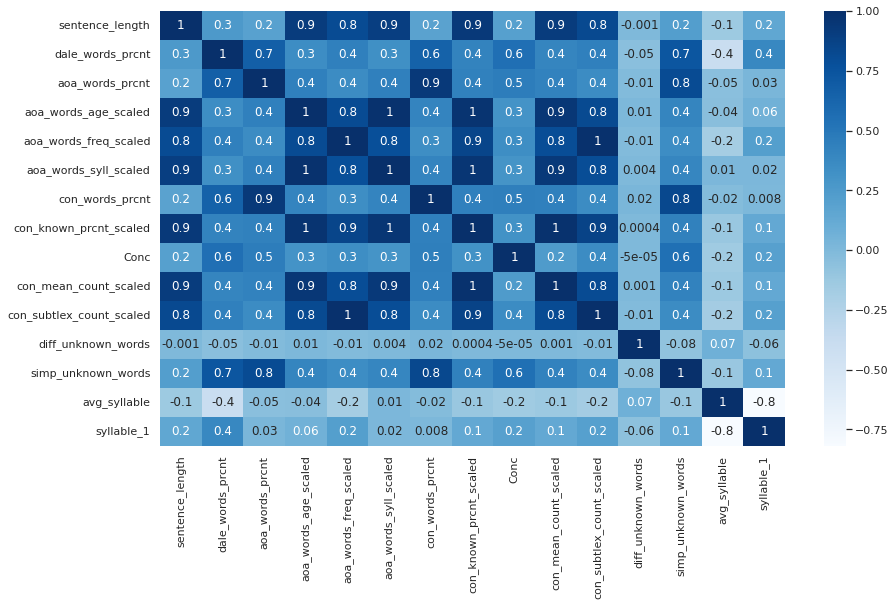

In [68]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [69]:
!pip install pycld2

Defaulting to user installation because normal site-packages is not writeable


In [70]:
import pycld2